# All Eigenvector Angle Statistics

**Goal:** Compute mean and std of angles for **ALL 2,560 eigenvectors** to understand the full geometric structure.

**Question:** How many eigenvectors do tokens avoid (perpendicular) vs. align with?

**Hypothesis:** 
- Top ~1,333 eigenvectors (significant eigenvalues): tokens perpendicular (mean ≈ 90°, std ≈ 1°)
- Bottom ~1,227 eigenvectors (near-zero eigenvalues): noise/undefined behavior

**Method:**
1. Load precomputed token projections
2. For EACH eigenvector: compute angle distribution statistics
3. Plot: mean angle, std angle vs. eigenvalue rank
4. Identify transition point where behavior changes

**What we learn:**
- Which eigenspace dimensions contain token mass
- Where the "true effective dimensionality" boundary is
- Whether tokens occupy a lower-dimensional subspace

## Configuration

In [1]:
# Data paths
EIGENBASIS_PATH = '../data/vectors/eigenbasis_qwen3_4b.pt'
PROJECTIONS_PATH = '../data/vectors/token_eigenbasis_projections_qwen3_4b.pt'

print(f"Configuration:")
print(f"  Will analyze ALL 2,560 eigenvectors")
print(f"  Computing mean and std angle for each")

Configuration:
  Will analyze ALL 2,560 eigenvectors
  Computing mean and std angle for each


## Setup

In [2]:
import numpy as np
import torch
import matplotlib.pyplot as plt

print("✓ Imports complete")

✓ Imports complete


## Load Precomputed Data

In [3]:
print("Loading precomputed eigenbasis data...\n")

# Load eigenbasis
print(f"Loading eigenbasis from {EIGENBASIS_PATH}...")
eigenbasis_data = torch.load(EIGENBASIS_PATH, weights_only=False)
eigenvalues = eigenbasis_data['eigenvalues'].numpy()
eigenvectors = eigenbasis_data['eigenvectors']

# Load token projections
print(f"Loading token projections from {PROJECTIONS_PATH}...")
projections_data = torch.load(PROJECTIONS_PATH, weights_only=False)
projections = projections_data['projections'].numpy()  # [vocab_size, hidden_dim]

vocab_size, hidden_dim = projections.shape

print(f"\n✓ Data loaded")
print(f"  Vocab size: {vocab_size:,}")
print(f"  Hidden dim: {hidden_dim:,}")
print(f"  Eigenvalues range: [{eigenvalues.min():.2f}, {eigenvalues.max():.2f}]")

Loading precomputed eigenbasis data...

Loading eigenbasis from ../data/vectors/eigenbasis_qwen3_4b.pt...
Loading token projections from ../data/vectors/token_eigenbasis_projections_qwen3_4b.pt...

✓ Data loaded
  Vocab size: 151,936
  Hidden dim: 2,560
  Eigenvalues range: [95.35, 94217.94]


## Compute Causal Norms

In [4]:
print("\nComputing causal norms from projections...")

# Causal norms: sqrt of sum of squared projections
causal_norms = np.linalg.norm(projections, axis=1)

print(f"✓ Causal norms computed")
print(f"  Range: [{causal_norms.min():.2f}, {causal_norms.max():.2f}] logometers")
print(f"  Mean: {causal_norms.mean():.2f} logometers")


Computing causal norms from projections...
✓ Causal norms computed
  Range: [0.36, 1.61] logometers
  Mean: 1.09 logometers


## Compute Angle Statistics for ALL Eigenvectors

For each eigenvector:
```
cos(θ) = |projection| / ||token||_M
θ = arccos(cos(θ))
```

We use absolute value to map to [0°, 90°] since we only care about alignment, not direction.

In [5]:
print("\n" + "=" * 80)
print("COMPUTING ANGLE STATISTICS FOR ALL EIGENVECTORS")
print("=" * 80)
print(f"\nProcessing {hidden_dim:,} eigenvectors...")
print("  This will take ~10-20 seconds...\n")

mean_angles = np.zeros(hidden_dim)
std_angles = np.zeros(hidden_dim)
median_angles = np.zeros(hidden_dim)

# Progress reporting
report_every = 256

for idx in range(hidden_dim):
    if idx % report_every == 0:
        print(f"  Progress: {idx:,} / {hidden_dim:,} ({100*idx/hidden_dim:.1f}%)")
    
    # Projection onto this eigenvector
    proj = projections[:, idx]
    
    # Cosine: |projection| / norm (absolute value to get angle in [0, 90])
    cosines = np.abs(proj) / causal_norms
    
    # Clip to valid range and compute angles
    cosines = np.clip(cosines, 0.0, 1.0)
    angles_rad = np.arccos(cosines)
    angles_deg = np.degrees(angles_rad)
    
    # Statistics
    mean_angles[idx] = angles_deg.mean()
    std_angles[idx] = angles_deg.std()
    median_angles[idx] = np.median(angles_deg)

print(f"\n✓ Angle statistics computed for all {hidden_dim:,} eigenvectors")


COMPUTING ANGLE STATISTICS FOR ALL EIGENVECTORS

Processing 2,560 eigenvectors...
  This will take ~10-20 seconds...

  Progress: 0 / 2,560 (0.0%)
  Progress: 256 / 2,560 (10.0%)
  Progress: 512 / 2,560 (20.0%)
  Progress: 768 / 2,560 (30.0%)
  Progress: 1,024 / 2,560 (40.0%)
  Progress: 1,280 / 2,560 (50.0%)
  Progress: 1,536 / 2,560 (60.0%)
  Progress: 1,792 / 2,560 (70.0%)
  Progress: 2,048 / 2,560 (80.0%)
  Progress: 2,304 / 2,560 (90.0%)

✓ Angle statistics computed for all 2,560 eigenvectors


## Summary Statistics

In [6]:
print("\n" + "=" * 80)
print("SUMMARY STATISTICS")
print("=" * 80)

print(f"\nMean angles across all eigenvectors:")
print(f"  Min: {mean_angles.min():.2f}°")
print(f"  Max: {mean_angles.max():.2f}°")
print(f"  Mean: {mean_angles.mean():.2f}°")
print(f"  Median: {np.median(mean_angles):.2f}°")

print(f"\nStd angles across all eigenvectors:")
print(f"  Min: {std_angles.min():.2f}°")
print(f"  Max: {std_angles.max():.2f}°")
print(f"  Mean: {std_angles.mean():.2f}°")
print(f"  Median: {np.median(std_angles):.2f}°")

# How many eigenvectors have tokens nearly perpendicular?
perpendicular_threshold = 2.0  # degrees from 90
num_perpendicular = np.sum(np.abs(mean_angles - 90.0) < perpendicular_threshold)
print(f"\nEigenvectors with mean angle ≈ 90° (±{perpendicular_threshold}°): {num_perpendicular:,} / {hidden_dim:,} ({100*num_perpendicular/hidden_dim:.1f}%)")


SUMMARY STATISTICS

Mean angles across all eigenvectors:
  Min: 75.05°
  Max: 89.85°
  Mean: 89.15°
  Median: 89.19°

Std angles across all eigenvectors:
  Min: 0.12°
  Max: 8.27°
  Mean: 0.65°
  Median: 0.63°

Eigenvectors with mean angle ≈ 90° (±2.0°): 2,552 / 2,560 (99.7%)


## Visualization: Mean Angle vs. Eigenvalue Rank

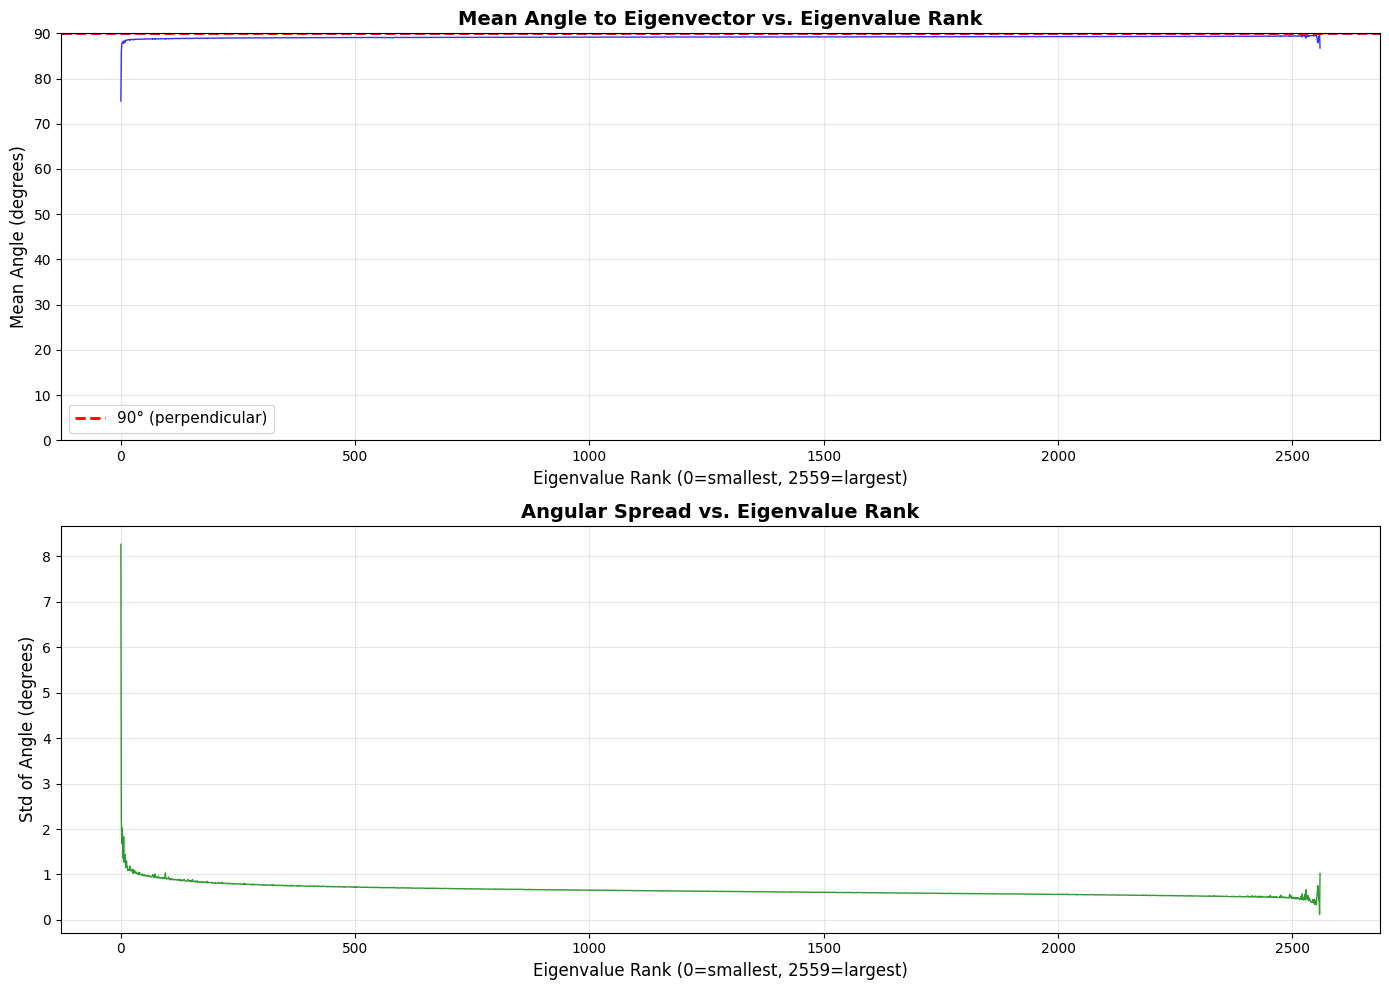


✓ Plots created


In [7]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

# Rank: 0 = smallest eigenvalue, 2559 = largest
ranks = np.arange(hidden_dim)

# Top plot: Mean angle
ax1.plot(ranks, mean_angles, linewidth=1, alpha=0.8, color='blue')
ax1.axhline(90, color='red', linestyle='--', linewidth=2, label='90° (perpendicular)')
ax1.set_xlabel('Eigenvalue Rank (0=smallest, 2559=largest)', fontsize=12)
ax1.set_ylabel('Mean Angle (degrees)', fontsize=12)
ax1.set_title('Mean Angle to Eigenvector vs. Eigenvalue Rank', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.legend(fontsize=11)
ax1.set_ylim(0, 90)

# Bottom plot: Std angle
ax2.plot(ranks, std_angles, linewidth=1, alpha=0.8, color='green')
ax2.set_xlabel('Eigenvalue Rank (0=smallest, 2559=largest)', fontsize=12)
ax2.set_ylabel('Std of Angle (degrees)', fontsize=12)
ax2.set_title('Angular Spread vs. Eigenvalue Rank', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✓ Plots created")

## Visualization: Zoomed View of Top Eigenvectors

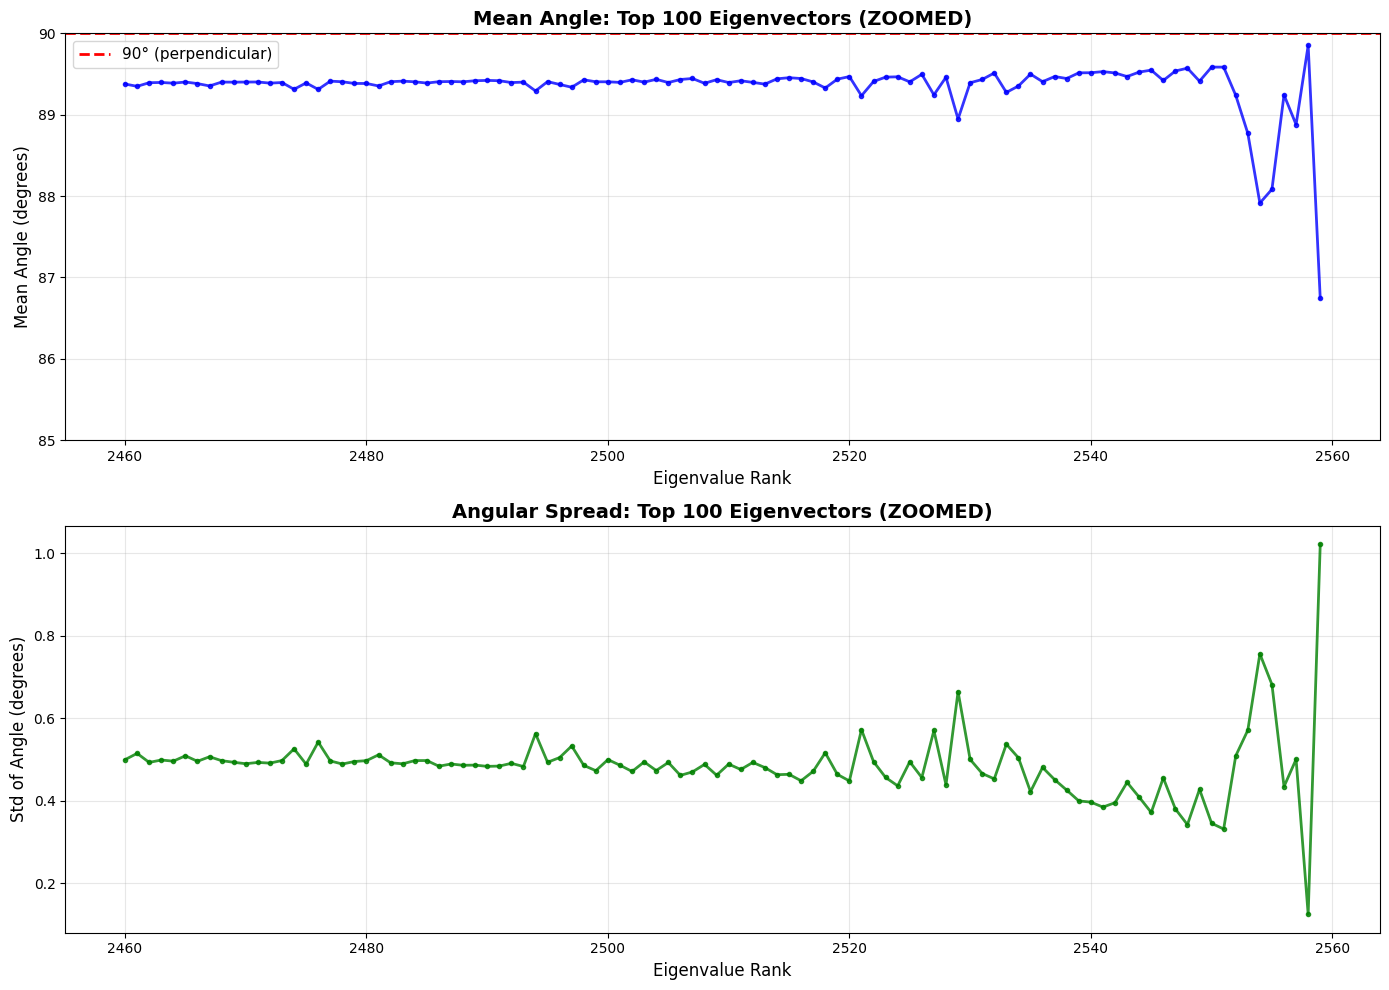


✓ Zoomed plots created (top 100 eigenvectors)


In [8]:
# Focus on top 100 eigenvectors (largest eigenvalues)
top_n = 100
top_ranks = ranks[-top_n:]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

# Top plot: Mean angle (zoomed)
ax1.plot(top_ranks, mean_angles[-top_n:], linewidth=2, alpha=0.8, color='blue', marker='o', markersize=3)
ax1.axhline(90, color='red', linestyle='--', linewidth=2, label='90° (perpendicular)')
ax1.set_xlabel('Eigenvalue Rank', fontsize=12)
ax1.set_ylabel('Mean Angle (degrees)', fontsize=12)
ax1.set_title(f'Mean Angle: Top {top_n} Eigenvectors (ZOOMED)', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.legend(fontsize=11)
ax1.set_ylim(85, 90)

# Bottom plot: Std angle (zoomed)
ax2.plot(top_ranks, std_angles[-top_n:], linewidth=2, alpha=0.8, color='green', marker='o', markersize=3)
ax2.set_xlabel('Eigenvalue Rank', fontsize=12)
ax2.set_ylabel('Std of Angle (degrees)', fontsize=12)
ax2.set_title(f'Angular Spread: Top {top_n} Eigenvectors (ZOOMED)', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n✓ Zoomed plots created (top {top_n} eigenvectors)")

## Visualization: Mean Angle vs. Eigenvalue Magnitude

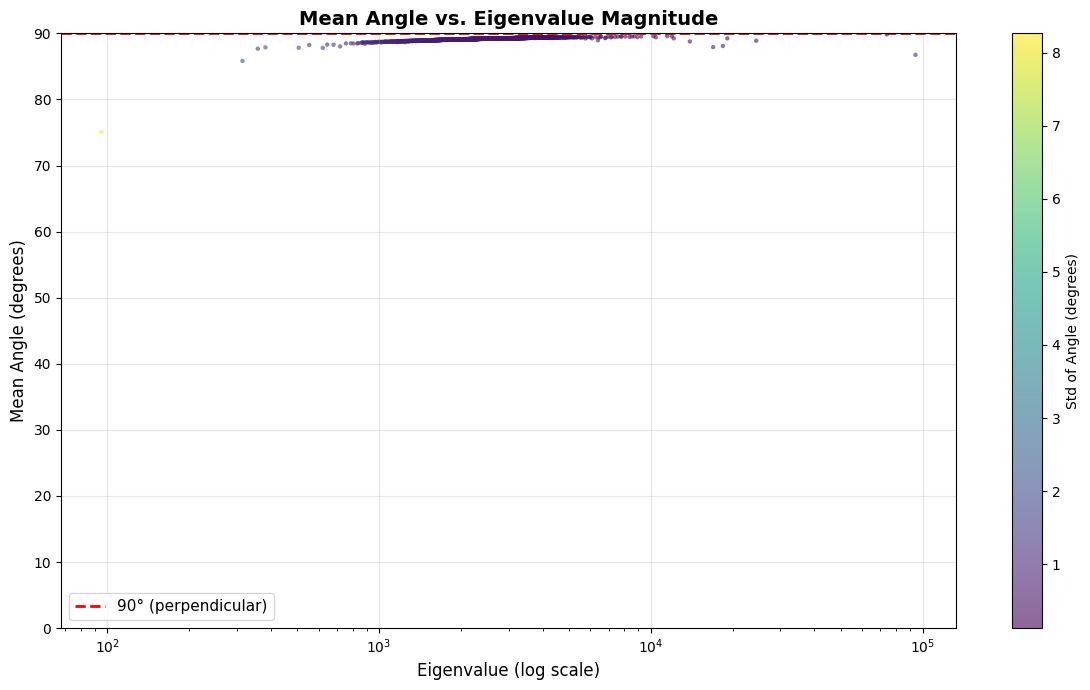


✓ Scatter plot created


In [9]:
fig, ax = plt.subplots(figsize=(12, 7))

# Scatter plot: eigenvalue vs mean angle
scatter = ax.scatter(eigenvalues, mean_angles, c=std_angles, cmap='viridis', 
                     s=10, alpha=0.6, edgecolors='none')

ax.axhline(90, color='red', linestyle='--', linewidth=2, label='90° (perpendicular)')
ax.set_xlabel('Eigenvalue (log scale)', fontsize=12)
ax.set_ylabel('Mean Angle (degrees)', fontsize=12)
ax.set_title('Mean Angle vs. Eigenvalue Magnitude', fontsize=14, fontweight='bold')
ax.set_xscale('log')
ax.set_ylim(0, 90)
ax.grid(True, alpha=0.3)
ax.legend(fontsize=11)

cbar = plt.colorbar(scatter, ax=ax, label='Std of Angle (degrees)')
cbar.ax.tick_params(labelsize=10)

plt.tight_layout()
plt.show()

print("\n✓ Scatter plot created")

## Identify Transition Point

Find where the behavior changes from "tokens perpendicular" to "tokens scattered".

In [10]:
print("\n" + "=" * 80)
print("IDENTIFYING TRANSITION POINT")
print("=" * 80)

# Define "perpendicular" as mean angle within 2° of 90°
perpendicular_mask = np.abs(mean_angles - 90.0) < 2.0

# Find the highest-rank eigenvector that's NOT perpendicular
non_perpendicular_ranks = ranks[~perpendicular_mask]

if len(non_perpendicular_ranks) > 0:
    transition_rank = non_perpendicular_ranks.max()
    transition_eigenvalue = eigenvalues[transition_rank]
    
    print(f"\nLast non-perpendicular eigenvector:")
    print(f"  Rank: {transition_rank}")
    print(f"  Eigenvalue: {transition_eigenvalue:.2f}")
    print(f"  Mean angle: {mean_angles[transition_rank]:.2f}°")
    
    num_perpendicular = np.sum(perpendicular_mask)
    print(f"\nEigenvectors with tokens perpendicular: {num_perpendicular:,} / {hidden_dim:,}")
    print(f"Eigenvectors with tokens aligned/scattered: {hidden_dim - num_perpendicular:,} / {hidden_dim:,}")
else:
    print("\nAll eigenvectors have tokens perpendicular (mean angle ≈ 90°)")
    print("Tokens occupy the full {hidden_dim}D space uniformly.")


IDENTIFYING TRANSITION POINT

Last non-perpendicular eigenvector:
  Rank: 2559
  Eigenvalue: 94217.94
  Mean angle: 86.74°

Eigenvectors with tokens perpendicular: 2,552 / 2,560
Eigenvectors with tokens aligned/scattered: 8 / 2,560


## Summary

**What we computed:** Mean and std of angles for **ALL 2,560 eigenvectors**.

**Key findings:**
- [Run notebook to see results!]

**Interpretation:**
- **Mean angle ≈ 90°, low std:** Tokens are perpendicular to this eigenvector (avoid high-variance directions)
- **Mean angle ≠ 90°:** Tokens have preferred alignment with this eigenvector
- **High std:** Tokens are scattered (no consistent relationship)

**Next steps:**
- 09.3b: Distribution histograms for individual eigenvectors
- 09.4: Correlation analysis between eigendirections
- 09.5: Project into low-variance subspace and visualize